## Detecting building defects using VGG16

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
tf.__version__

'2.4.4'

### Importing and Understanding the dataset

In [6]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_014b67e2d1194d2287dbf89f726d3163 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='8LvL7MAREwQS3_4iWQmzgTR5A91784vH6mGnYz1CKKMY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

streaming_body_2 = client_014b67e2d1194d2287dbf89f726d3163.get_object(Bucket='defectdetectionmodel-donotdelete-pr-wxlwquxy4npqao', Key='data.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [7]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [8]:
pwd

'/home/wsuser/work'

In [9]:
# walk through the folder to know the content

import pathlib
import os

for dirpath, dirname, filenames in os.walk("/home/wsuser/work/data"):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /home/wsuser/work/data
There are 3 directories and 0 images in /home/wsuser/work/data/test_set
There are 0 directories and 51 images in /home/wsuser/work/data/test_set/flakes
There are 0 directories and 37 images in /home/wsuser/work/data/test_set/roof
There are 0 directories and 32 images in /home/wsuser/work/data/test_set/crack
There are 3 directories and 0 images in /home/wsuser/work/data/train_set
There are 0 directories and 176 images in /home/wsuser/work/data/train_set/flakes
There are 0 directories and 54 images in /home/wsuser/work/data/train_set/roof
There are 0 directories and 86 images in /home/wsuser/work/data/train_set/crack


In [10]:
# get the names of the classes
import numpy as np

data_dir = pathlib.Path("/home/wsuser/work/data/test_set")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['crack' 'flakes' 'roof']


In [11]:
# visualize the data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Create a function to show random images from dataset
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    print(target_folder)

    random_image = random.sample(os.listdir(target_folder), 1)

    # plot image using matplotlib
    img = mpimg.imread(target_folder+ "/" + random_image[0])
    plt.imshow(img)
    plt.axis(False)
    plt.title(target_class)
    print(f"Image shape : {img.shape}")

/home/wsuser/work/data/train_set/roof
Image shape : (406, 612, 3)


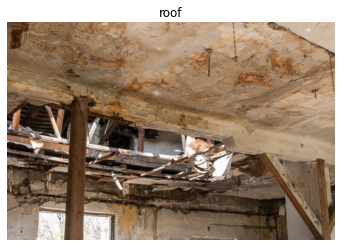

In [13]:
# view random image from training set
view_random_image("/home/wsuser/work/data/train_set/", "roof")

#### Image preprocessing 

In [14]:
# importing ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# get the directory path
train_dir = "/home/wsuser/work/data/train_set"
test_dir = "/home/wsuser/work/data/test_set"

# Create instances for training and test data
train_datagen = ImageDataGenerator(rescale= 1./255,
                                    shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True)

test_datagen = ImageDataGenerator(rescale= 1./255)

# Create the test and train data
train_data = train_datagen.flow_from_directory(directory= train_dir,
                                                target_size= (224,224),
                                                batch_size= 32,
                                                class_mode= 'categorical')
                                                
test_data = test_datagen.flow_from_directory(directory= test_dir,
                                                target_size= (224,224),
                                                batch_size= 32,
                                                class_mode= 'categorical')

Found 316 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


#### Creating the model

In [15]:
# imports 
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model


In [16]:

# vgg16 model (Feature extractor) 
INPUT_SHAPE =   (224,224,3)
vgg16_model = VGG16(include_top= False, weights= 'imagenet')
vgg16_model.trainable = False # Freeze the base model

# Create the model using the keras functional API
inputs = layers.Input(shape = INPUT_SHAPE, name = "input_layer")
x = vgg16_model(inputs, training = False)
x = layers.Flatten(name = "flatten_layer")(x)
x = layers.Dense(64, activation= 'relu')(x)
outputs = layers.Dense(len(class_names), activation= "softmax", name = "output_layer")(x)

model_1 = Model(inputs = inputs, outputs = outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [17]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_layer (Flatten)      (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
output_layer (Dense)         (None, 3)                 195       
Total params: 16,320,579
Trainable params: 1,605,891
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Train the model
history_1 = model_1.fit(
    train_data,
    validation_data = test_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_steps = len(test_data)
)

Epoch 1/10
10/10 [==============================] - 190s 19s/step - loss: 3.0291 - accuracy: 0.4162 - val_loss: 1.3134 - val_accuracy: 0.4417
Epoch 2/10
10/10 [==============================] - 188s 19s/step - loss: 0.9288 - accuracy: 0.5930 - val_loss: 0.7888 - val_accuracy: 0.6250
Epoch 3/10
10/10 [==============================] - 188s 19s/step - loss: 0.6785 - accuracy: 0.6797 - val_loss: 0.7143 - val_accuracy: 0.6917
Epoch 4/10
10/10 [==============================] - 188s 19s/step - loss: 0.6196 - accuracy: 0.7062 - val_loss: 0.6730 - val_accuracy: 0.6833
Epoch 5/10
10/10 [==============================] - 188s 19s/step - loss: 0.5544 - accuracy: 0.7873 - val_loss: 0.7232 - val_accuracy: 0.6833
Epoch 6/10
10/10 [==============================] - 188s 19s/step - loss: 0.4563 - accuracy: 0.8685 - val_loss: 0.6813 - val_accuracy: 0.7083
Epoch 7/10
10/10 [==============================] - 189s 19s/step - loss: 0.4253 - accuracy: 0.8941 - val_loss: 0.6489 - val_accuracy: 0.7417
Epoch 

#### Evaluating the model

In [19]:
# plotting the learning curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize= (10,7))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize= (10,7))
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

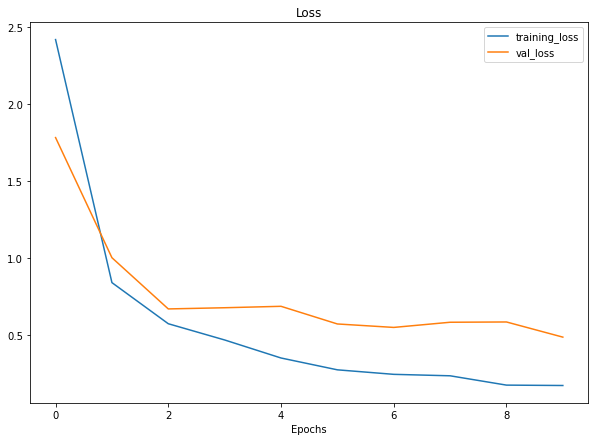

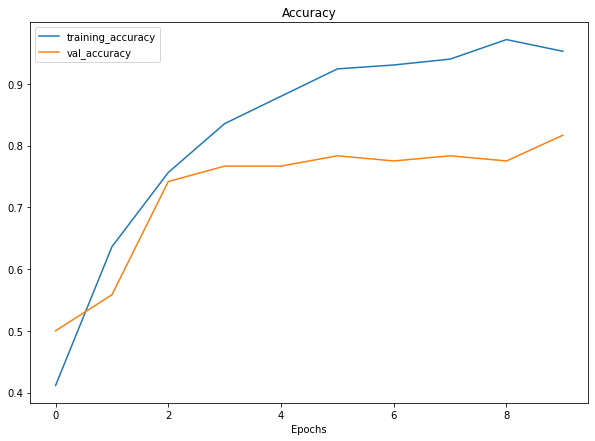

In [82]:
plot_loss_curves(history_1)

In [20]:
# saving the model
from tensorflow.keras.models import save_model

model_1.save('model_building_defects_vgg16.h5')

In [84]:
# Testing the model named - model_building_defects_vgg16_custom.h5

model_1.evaluate(test_data)

4/4 [==============================] - 1s 258ms/step - loss: 0.4850 - accuracy: 0.8167


[0.4849936068058014, 0.8166666626930237]

In [21]:
!tar -zcvf model_building_defects.tgz model_building_defects_vgg16.h5

model_building_defects_vgg16.h5


In [22]:
ls

data/  model_building_defects.tgz  model_building_defects_vgg16.h5


In [23]:
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 538 kB 20.3 MB/s eta 0:00:01


In [24]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "9sWtt6Q0H0btR1guAZ9lmYdIh2ltuzvAn5paSe9c7Hza"
}

client = APIClient(wml_credentials)

In [25]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']['name'] == space_name)['metadata']['id'])

In [26]:
space_uid = guid_from_space_name(client,'Detection of building defects')
print("Space UID = " + space_uid)

Space UID = cc6412ed-a08e-4cc1-a227-6fd0ab3463c8


In [28]:
client.set.default_space(space_uid)

'SUCCESS'

In [87]:
# Loading the model - model_building_defects_vgg16.h5
from tensorflow.keras.models import load_model

loaded_model = load_model("model_building_defects_vgg16.h5")

In [30]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [ ]:
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_2.4-py3.8")
software_spec_uid

In [88]:
loaded_model.evaluate(test_data)

4/4 [==============================] - 2s 286ms/step - loss: 0.4850 - accuracy: 0.8167


[0.48499366641044617, 0.8166666626930237]

#### Making predictions using the model

In [49]:
# using an image to make predictions
def pred_and_plot(model_name, filename, img_shape = 224):
  random_image = random.sample(os.listdir(filename), 1)
  img = tf.io.read_file(filename + "/" + random_image[0])
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  show_img = img/255.

  # make prediction
  pred = model_name.predict(tf.expand_dims(img, axis =0))
  
  # get the pred class
  pred_class = class_names[tf.argmax(pred[0])]

  # plot the image with prediction
  plt.imshow(show_img)
  plt.title(f"Predicted defect : {pred_class}")
  plt.axis(False)

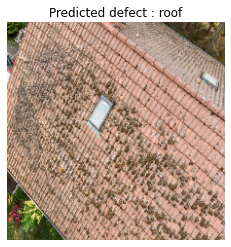

In [93]:
pred_and_plot(loaded_model, "../data/test_set/roof")